In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import time
import psutil
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from collections import Counter
import warnings
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [ ]:
import time
import psutil
import os
# Hàm để lấy thông tin RAM và disk usage
def get_system_usage():
    # RAM usage
    memory_info = psutil.virtual_memory()
    ram_usage = memory_info.used / (1024 ** 3)  # convert to GB

    # Disk usage
    disk_info = psutil.disk_usage('/')
    disk_usage = disk_info.used / (1024 ** 3)  # convert to GB

    return ram_usage, disk_usage

# Ghi nhận thời gian bắt đầu và thông tin hệ thống
start_time = time.time()
initial_ram_usage, initial_disk_usage = get_system_usage()

# Chạy Tay RDF

# Cài đặt Mô Hình Cây Quyết Định

In [ ]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [ ]:
# Lớp Cây Quyết định
class DecisionTreeClassifier:
    def __init__(self, min_samples_split=2, max_depth=20, n_features=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None
        self.feature_importances_ = None

    def fit(self, X, y):
        self.n_features = X.shape[1]
        self.feature_importances_ = np.zeros(self.n_features)
        self.root = self._grow_tree(X, y)
        self._normalize_feature_importances()
        return self

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        self.feature_importances_[best_feature] += self._information_gain(y, X[:, best_feature], best_thresh)

        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)

        return Node(best_feature, best_thresh, left, right)

    def _normalize_feature_importances(self):
        total_importance = np.sum(self.feature_importances_)
        if total_importance > 0:
            self.feature_importances_ /= total_importance

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        parent_entropy = self._entropy(y)
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        return parent_entropy - child_entropy

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p > 0])

    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

# Cài đặt Mô hình RF by hand

In [ ]:
import numpy as np
from sklearn.utils import resample

class RandomForestClassifier:
    def __init__(self, n_trees=300, min_samples_split=2, max_depth=20, n_features=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTreeClassifier(
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth,
                n_features=self.n_features
            )
            X_sample, y_sample = resample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=tree_preds)

    def feature_importances(self):
        importances = np.zeros(self.trees[0].n_features)
        for tree in self.trees:
            importances += tree.feature_importances_
        return importances / self.n_trees

# Run RF by hand

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Tải tệp CSV
features_train_file_path = '/content/drive/MyDrive/KHDL/Dataset/3labels_features_train.csv'
features_test_file_path = '/content/drive/MyDrive/KHDL/Dataset/3labels_features_test.csv'

features_train_df = pd.read_csv(features_train_file_path)
features_test_df = pd.read_csv(features_test_file_path)

# Hiển thị cột
print(features_train_df.columns)
print(features_test_df.columns)

Index(['mean_intensity', 'variance_intensity', 'skewness_intensity',
       'kurtosis_intensity', 'entropy_intensity', 'energy_intensity',
       'contrast_0', 'contrast_45', 'contrast_90', 'contrast_135',
       'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90',
       'dissimilarity_135', 'homogeneity_0', 'homogeneity_45',
       'homogeneity_90', 'homogeneity_135', 'energy_0', 'energy_45',
       'energy_90', 'energy_135', 'correlation_0', 'correlation_45',
       'correlation_90', 'correlation_135', 'label'],
      dtype='object')
Index(['mean_intensity', 'variance_intensity', 'skewness_intensity',
       'kurtosis_intensity', 'entropy_intensity', 'energy_intensity',
       'contrast_0', 'contrast_45', 'contrast_90', 'contrast_135',
       'dissimilarity_0', 'dissimilarity_45', 'dissimilarity_90',
       'dissimilarity_135', 'homogeneity_0', 'homogeneity_45',
       'homogeneity_90', 'homogeneity_135', 'energy_0', 'energy_45',
       'energy_90', 'energy_135', 'correlation_

In [ ]:

# Bỏ qua tất cả các cảnh báo
warnings.filterwarnings('ignore')

# Đọc dữ liệu
features_df = features_train_df

# Loại bỏ cột 'label' khỏi tập đặc trưng
features = features_df.drop(columns=['label'])

# Chuyển đổi các giá trị đặc trưng thành dạng rời rạc
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
discrete_features = discretizer.fit_transform(features)

# Chuyển đổi ngược lại thành DataFrame để dễ xử lý
discrete_features_df = pd.DataFrame(discrete_features, columns=features.columns)

# Tạo danh sách giao dịch có gắn nhãn đặc trưng
transactions_list = [[f'{col}_{int(val)}' for col, val in row.items()] for index, row in discrete_features_df.iterrows()]

# Sử dụng TransactionEncoder để chuyển đổi danh sách giao dịch thành DataFrame nhị phân
te = TransactionEncoder()
binary_features_df = pd.DataFrame(te.fit(transactions_list).transform(transactions_list), columns=te.columns_)

# Sử dụng thuật toán Apriori để tìm các tập hợp thường xuyên
frequent_itemsets = apriori(binary_features_df, min_support=0.6, use_colnames=True)

# Tạo các luật kết hợp từ các tập hợp thường xuyên
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

# Đánh giá các luật dựa trên các chỉ số
min_support = 0.6
min_confidence = 0.7
min_lift = 1.0
evaluated_rules = rules[(rules['support'] >= min_support) & (rules['confidence'] >= min_confidence) & (rules['lift'] >= min_lift)]

# Xác định các thuộc tính quan trọng từ các luật kết hợp
important_features = pd.Series(evaluated_rules['antecedents'].tolist() + evaluated_rules['consequents'].tolist()).value_counts()
important_features_df = important_features.reset_index()
important_features_df.columns = ['attribute', 'count']

# Chuyển đổi frozenset thành chuỗi và lấy tên các thuộc tính gốc
def extract_feature_names(frozenset_str):
    return [feat.split('_')[0] for feat in frozenset_str.replace('frozenset({', '').replace('})', '').replace("'", "").replace('(', '').replace(')', '').split(', ')]

important_original_features = set()
for item in important_features_df['attribute'].tolist():
    if isinstance(item, str) and 'frozenset' in item:
        item = eval(item)
    if isinstance(item, frozenset):
        for sub_item in item:
            important_original_features.update(extract_feature_names(sub_item))
    else:
        important_original_features.update(extract_feature_names(item))

important_original_features = list(important_original_features)
important_original_features.append('label')

print("Các thuộc tính gốc quan trọng:")
print(important_original_features)



Các thuộc tính gốc quan trọng:
['entropy', 'contrast', 'correlation', 'homogeneity', 'energy', 'label']


In [ ]:
# Lấy các giá trị duy nhất trong cột attribute
unique_attributes = important_features_df['attribute'].unique()

# Chuyển đổi frozenset thành danh sách các thuộc tính gốc dễ hiểu
important_features_list = set()
for attr in unique_attributes:
    if isinstance(attr, frozenset):
        important_features_list.update(attr)
    else:
        important_features_list.add(attr)
# Hiển thị danh sách các thuộc tính gốc dễ hiểu
print("Danh sách các thuộc tính gốc dễ hiểu :")
print(important_features_list)

Danh sách các thuộc tính gốc dễ hiểu :
{'energy_45_0', 'contrast_135_0', 'entropy_intensity_3', 'correlation_90_0', 'energy_intensity_6', 'homogeneity_0_0'}


In [ ]:
important_features = ['entropy_intensity', 'energy_intensity','correlation_90', 'contrast_135','variance_intensity','homogeneity_0','energy_45','label']

In [ ]:
features_train_df = features_train_df[important_features]
features_test_df = features_test_df[important_features]

In [ ]:
# Tạo tập dữ liệu từ F/s gốc - PP2
X_train = features_train_df.drop('label', axis=1)
y_train = features_train_df['label']
X_test = features_test_df.drop('label', axis=1)
y_test = features_test_df['label']

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Mã hóa nhãn
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Khởi tạo mô hình RandomForest
model = RandomForestClassifier()

# Huấn luyện mô hình
model.fit(X_train_scaled, y_train_encoded)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test_scaled)

# Kết Quả Chạy Tay RDF PP1

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Đánh giá mô hình
accuracy = accuracy_score(y_test_encoded, y_pred)
report = classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)


Accuracy: 0.7391304347826086
Classification Report:
                    precision    recall  f1-score   support

Michelia chapensis       0.71      0.83      0.76        35
          Platanus       0.72      0.64      0.68        28
Sapindus saponaria       0.81      0.72      0.76        29

          accuracy                           0.74        92
         macro avg       0.75      0.73      0.74        92
      weighted avg       0.74      0.74      0.74        92



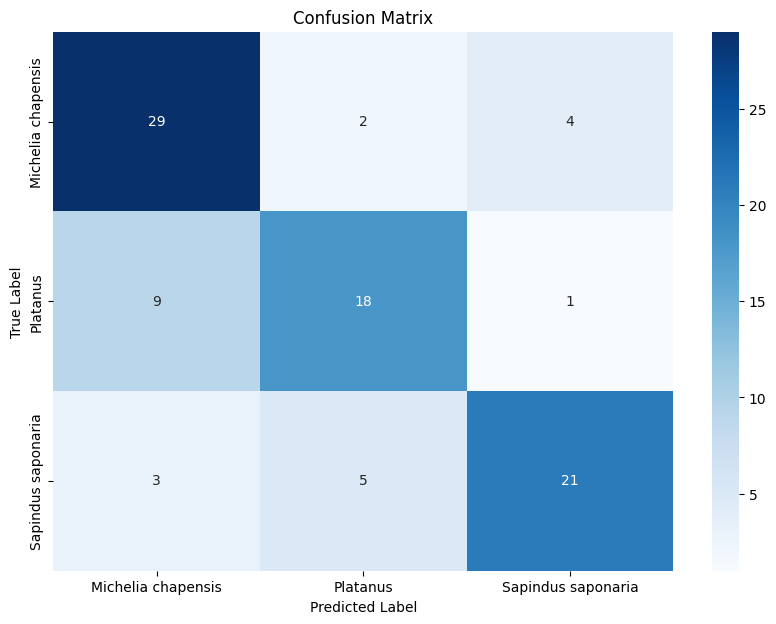

In [ ]:
# Trực quan hóa ma trận nhầm lẫn
cm = confusion_matrix(y_test_encoded, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Ghi nhận thời gian kết thúc và thông tin hệ thống
end_time = time.time()
final_ram_usage, final_disk_usage = get_system_usage()

# Tính toán thời gian chạy, RAM và disk usage
execution_time = end_time - start_time
ram_usage_diff = final_ram_usage - initial_ram_usage
disk_usage_diff = final_disk_usage - initial_disk_usage

print(f'Execution Time: {execution_time} seconds')
print(f'RAM Usage Increase: {ram_usage_diff} GB')
print(f'Disk Usage Increase: {disk_usage_diff} GB')

Execution Time: 835.9249339103699 seconds
RAM Usage Increase: -0.12874603271484375 GB
Disk Usage Increase: 0.00070953369140625 GB
